## IGAE

The following code is used to create and update monthly figures of the Mexican economic activity indicator (IGAE)

In [1]:
import sys
import os
import pandas as pd
import numpy as np


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

### Getting the data

In [2]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity"
    ],
    "categories": {
        "adjustment_type": [
            "61060325ab095ed"
        ],
        "economic_activity": "all"
    },
    "request": [
        {
            "table": "mex_inegi_igae",
            "variables": [
                "fa581e55c3b52cb"
            ]
        }
    ],
    "from": "2000-01-01"
}

response = get_tukan_api_request(payload)

Success getting the data


In [3]:
df = response["data"]

### Global Economic Activity

In [4]:
df_global = df[df["economic_activity__ref"] == "dfeefc621d16d0c"].copy()
df_global.reset_index(drop = True, inplace = True)
df_global.loc[:,"mom"] = df_global["fa581e55c3b52cb"]/df_global["fa581e55c3b52cb"].shift(1) - 1
df_global.loc[:,"yoy"] = df_global["fa581e55c3b52cb"]/df_global["fa581e55c3b52cb"].shift(12) - 1 

In [5]:
# Check if there has been a MoM contraction
df_global.loc[:,"contraction"] = [True if x < 0 else False for x in df_global["mom"]]
# df_global

In [12]:
# Count for consecutive contractions.

df_global_bool = df_global["contraction"] != df_global["contraction"].shift()
df_cum = df_global_bool.cumsum()

groups = df_global.where(df_global['contraction'] == True).groupby(df_cum)


groupCounts = groups.agg({'date':['count', 'min', 'max']})
groupCounts.columns = groupCounts.columns.droplevel()
groupCounts[groupCounts["count"] > 3]


,count,min,max
contraction,,,
4,8,2000-10-01,2001-05-01
52,7,2008-11-01,2009-05-01
110,4,2020-02-01,2020-05-01


In [9]:
df_global["mom"].tail(5)*100

258    0.163379
259   -1.180802
260   -0.297781
261   -0.168754
262    0.349502
Name: mom, dtype: float64

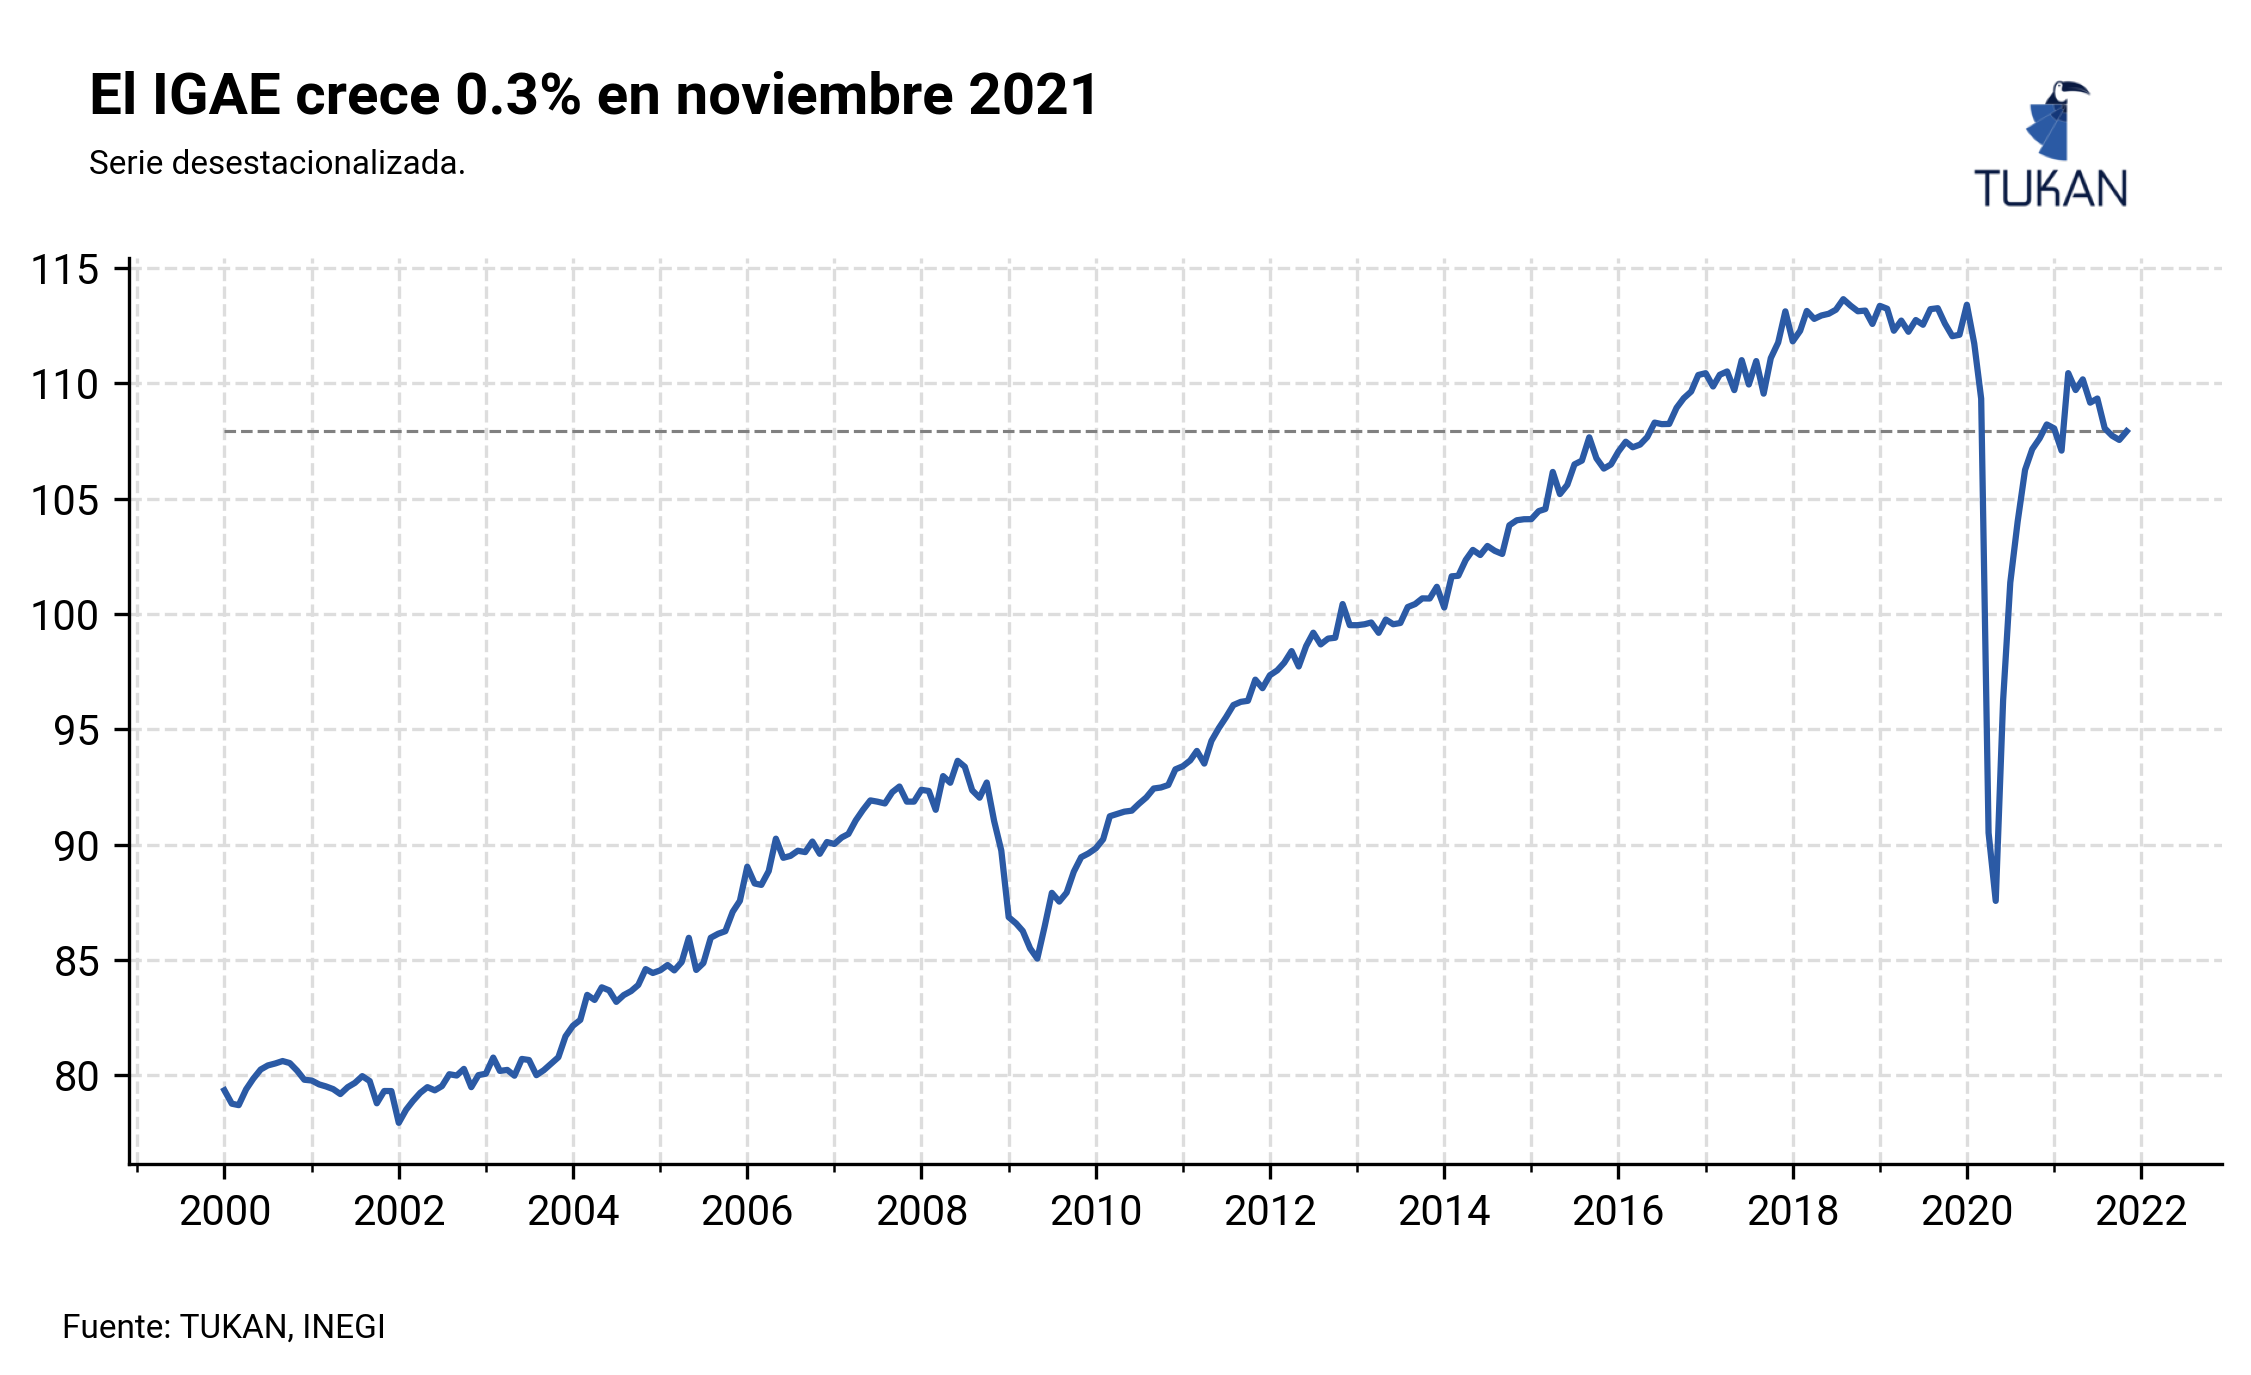

In [11]:
fig = plt.figure(dpi=300, figsize=(9,4))
ax = plt.subplot(111)

ax.hlines(y = df_global["fa581e55c3b52cb"].iloc[-1], xmin = df_global["date"].iloc[0], xmax = df_global["date"].iloc[-1], color = "gray", ls = "--", linewidths = 0.75)
ax.plot(df_global["date"], df_global["fa581e55c3b52cb"])

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))

ax.grid(visible=True, which='minor', linestyle='--')


# ax.set_ylim(0)

fig.text(
    0.11,
    1,
    "El IGAE crece 0.3% en noviembre 2021",
    size=14,
    weight = "bold"
)

fig.text(
    0.11,
    0.95,
    "Serie desestacionalizada.",
    size=8
)
# Add footer
fig.text(0.1, -0.02, "Fuente: TUKAN, INEGI", fontsize=8)


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/igae_ts_logo_white.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)